In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from tqdm import tqdm
from tensorflow.keras.regularizers import l2
from functools import partial

# Data
from data.data_generator import data_generator
from data.data_generator import data_model
from data.data_filtering import (sanity_checks, est_sanity_checks)

# Model
from models.models import HeteroskedasticModel
from models.models import BayesFlow

# Utils
from utils.losses import heteroskedastic_loss, maximum_likelihood_loss
from utils.training import train_step
from utils.viz import plot_true_est_scatter
from utils.viz import plot_true_est_posterior
from utils.viz import plot_correlation_parameters
from utils.viz import plot_comp_post_prior
# from utils.viz import plot_variance

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Using Heteroskedastic model as summary net
class SummaryNet(tf.keras.Model):
    def __init__(self, meta):
        super(CustomSummaryNetwork, self).__init__()
        pass
    
    def call(self, x):
        """
        Performs a forward pass through the summary network
        Arguments:
        x : tf.Tensor of shape (batch_size, n_obs, x_dim) - a batch of samples from p(x|params)
        """
        
        # Do something with input
        
        return x

### Training hyperparameters

In [4]:
# Network hyperparameters
inv_meta = {
    'n_units': [64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}
n_inv_blocks = 5

# Optional if using the predefined summary nets
summary_meta = {
    'n_units': [192, 192, 192],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}


# Forward model hyperparameters
parameter_names = [r'$\beta$', r'$\alpha$', r'$\gamma$', r'$\delta$', r'$\rho$']
theta_dim = len(parameter_names)
n_test = 500


# Training and optimizer hyperparameters
ckpt_file = "SEIDR"
batch_size = 64
epochs = 100
iterations_per_epoch = 1000
n_samples_posterior = 2000

starter_learning_rate = 0.001
global_step = tf.Variable(0, dtype=tf.int32)
decay_steps = 1000
decay_rate = .95
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(starter_learning_rate, decay_steps, decay_rate)
optimizer = tf.keras.optimizers.Adam(learning_rate)

### Test Data

In [5]:
%%time
data_test = data_generator(n_test)

# Preprocessing untrained data
x_test = np.array(data_test['x'])
theta_test = np.array(data_test['theta'])

CPU times: user 144 ms, sys: 4.36 ms, total: 149 ms
Wall time: 146 ms


In [6]:
print(type(x_test))
print(x_test.shape)
print(type(theta_test))
print(theta_test.shape)

<class 'numpy.ndarray'>
(500, 100, 5)
<class 'numpy.ndarray'>
(500, 5)


In [7]:
# Sanity checks
x_test, theta_test = sanity_checks(x_test, theta_test)

# Sanity checks for numerical stability
assert(np.sum(x_test == np.inf) == 0)
assert(np.sum(x_test == -np.inf) == 0)
assert(np.sum(x_test == np.nan) == 0)

# Reshape x
x_test = x_test.reshape(x_test.shape[0], -1)

In [8]:
print(x_test.shape)
print(theta_test.shape)

(500, 500)
(500, 5)


### Networks

In [9]:
# Instantiate model
summary_net = HeteroskedasticModel(summary_meta)
model = BayesFlow(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)

### Compile

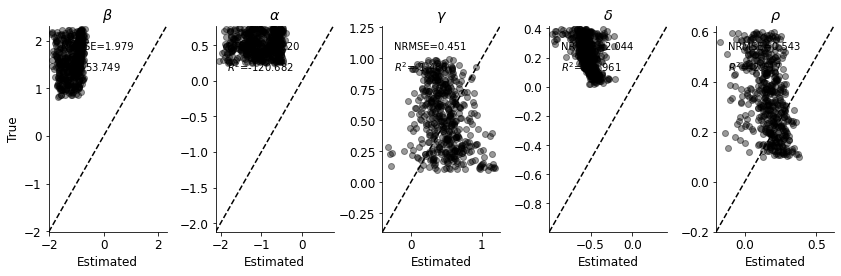

In [10]:
plot_true_est_scatter(model, x_test, theta_test, n_samples_posterior, parameter_names, figsize=(12, 4))

### Manage Checkpoints

In [11]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=3)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/SEIDR/ckpt-612


### Training network

In [12]:
# %%time
for ep in range(1, epochs + 1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_step(model=model, 
                            optimizer=optimizer,
                            loss_fn=maximum_likelihood_loss, 
                            iterations=iterations_per_epoch,
                            batch_size=batch_size,
                            p_bar=p_bar,
                            global_step=global_step) 

        # Manage checkpoint
        manager.save()

Training epoch 100: 100%|██████████| 1000/1000 [01:43<00:00,  9.64it/s, Iteration: 1000, Loss: -31.573402404785156]


### Posterior means & Full posteriors

In [12]:
# Estimation sanity checks
theta_approx_means = model.sample(x_test, n_samples_posterior, to_numpy=True).mean(axis=0)
theta_approx_means, y_test, theta_test = est_sanity_checks(theta_approx_means, theta_test)

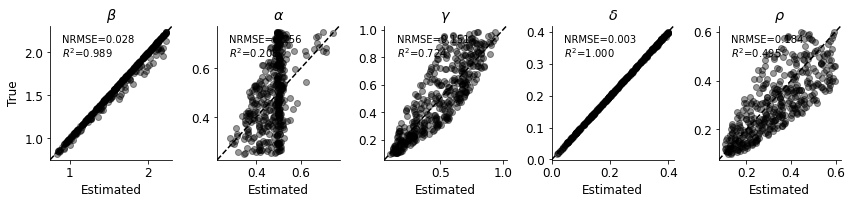

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


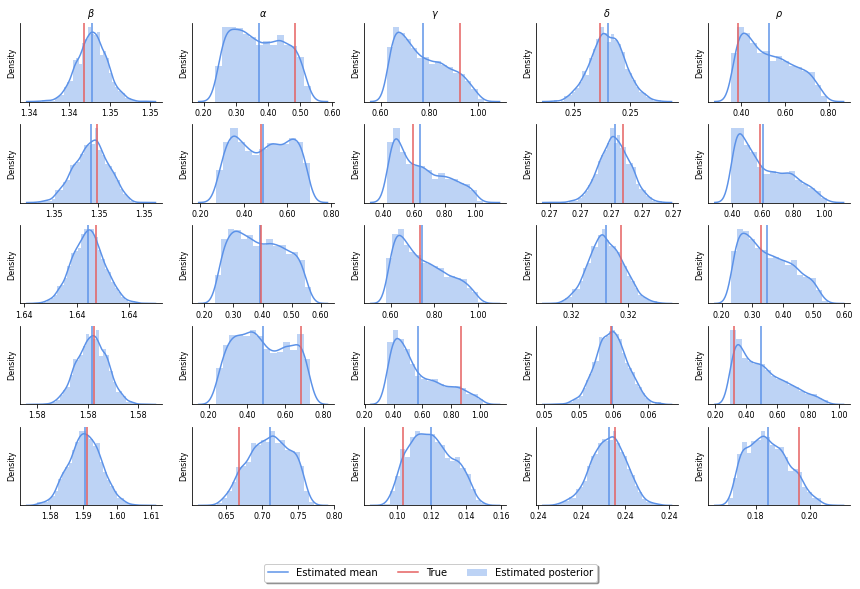

In [14]:
plot_true_est_scatter(model, x_test, y_test, n_samples_posterior, parameter_names, figsize=(12, 3), theta_approx_means=theta_approx_means)

plot_true_est_posterior(model, 2000, parameter_names, font_size=8,
                        X_test=x_test[:5], 
                        theta_test=theta_test[:5], figsize=(12, 8))

### Correlation of parameters

In [15]:
theta_approx_means = model.sample(x_test, n_samples_posterior, to_numpy=True).mean(axis=0)

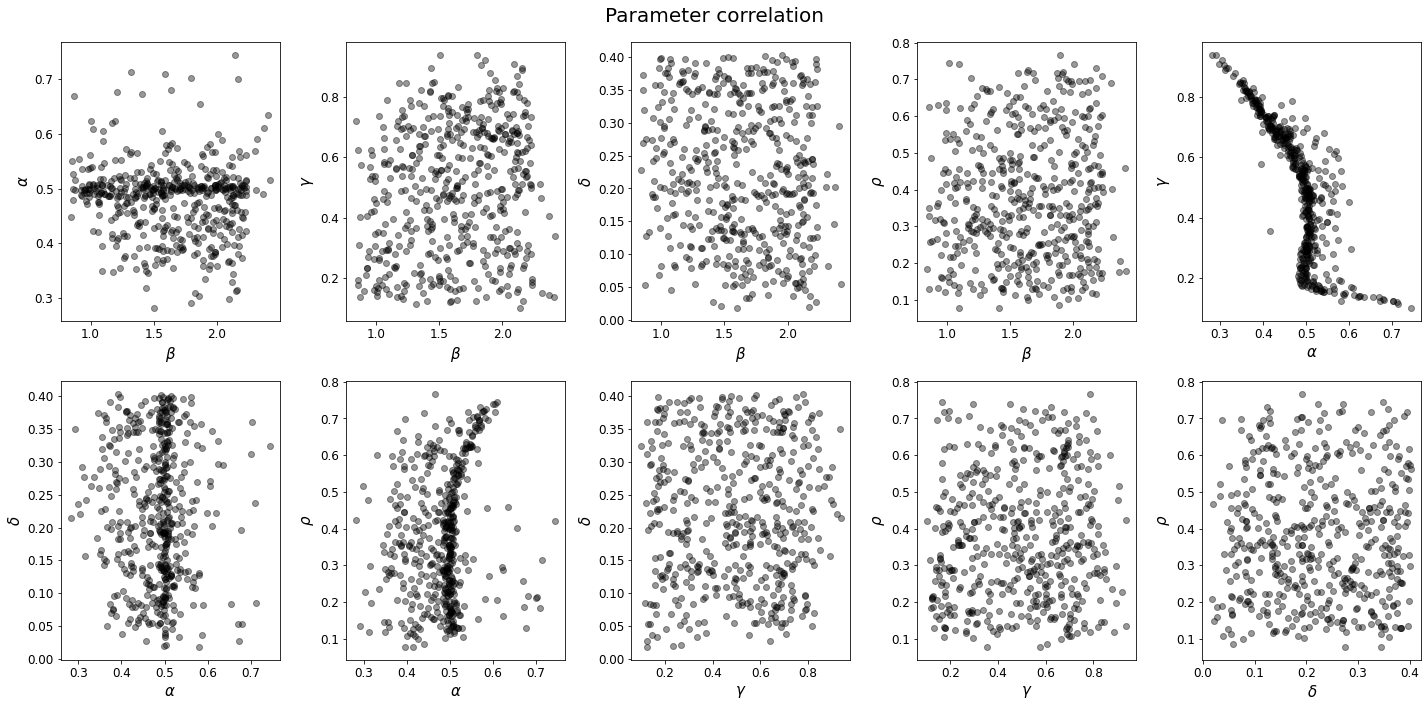

<Figure size 1440x720 with 0 Axes>

In [16]:
plot_correlation_parameters(theta_approx_means, parameter_names)

### Re-simulation

In [17]:
n_samples = 2000
theta_samples = model.sample(x_test, n_samples_posterior, to_numpy=True)

In [18]:
# Select random sample
rand_sample_idx = np.random.choice(theta_samples.shape[0], 1, replace=False)
sel_sample = theta_samples[rand_sample_idx].squeeze()
filt_sel_sample, y_test, _ = est_sanity_checks(sel_sample, theta_test)

In [19]:
# Forward model using selected sample
t_obs = 100
dt = 1
t = np.linspace(0, t_obs, int(t_obs/dt))
N = 10000
init_vals = 1 - 1/N, 1/N, 0, 0, 0
forward_model = partial(data_model, initial_values=init_vals)

ts = np.empty((filt_sel_sample.shape[0], t_obs, 5))
          
for i in range(filt_sel_sample.shape[0]):
    ts[i, :, :] = forward_model(filt_sel_sample[i, :], t=t)

ts = ts.reshape(sel_sample.shape[0], -1)

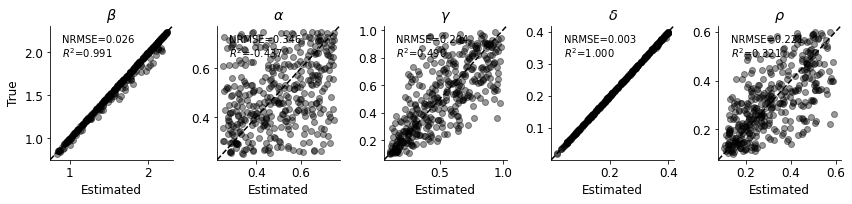

In [20]:
plot_true_est_scatter(model, ts, y_test, n_samples_posterior, parameter_names, figsize=(12, 3), theta_approx_means=filt_sel_sample)

### Compartiment time series

In [21]:
# Estimation sanity check
rand_test_data_index = np.random.choice(filt_sel_sample.shape[0], 1, replace=False)
sel_params = filt_sel_sample[rand_test_data_index].squeeze()
sel_params.shape

(5,)

In [22]:
# parameters = np.array([0.97, 0.5, 0.17, 0.12, 0.07])
parameters = sel_params

ts = forward_model(parameters, t=t)
labels = ['S', 'E', 'I', 'R', 'D']
print(ts.shape)

(100, 5)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


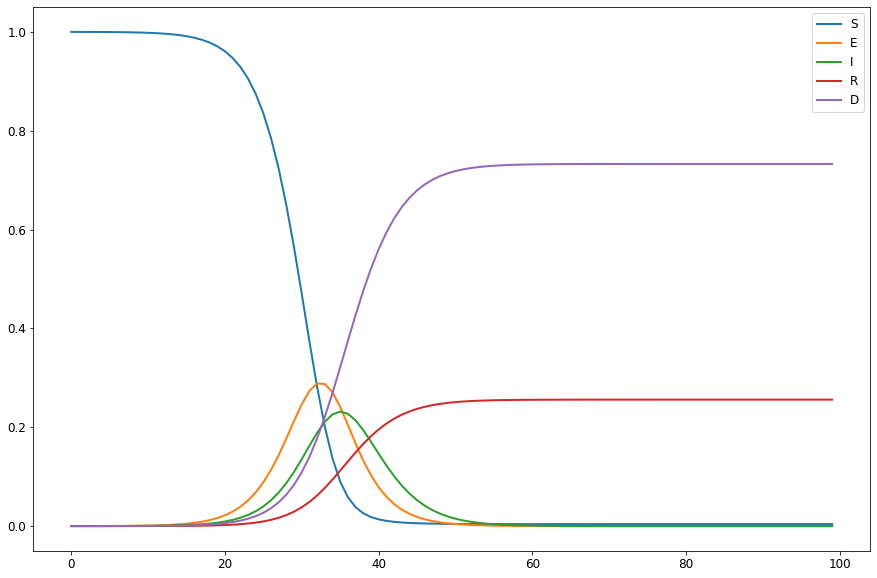

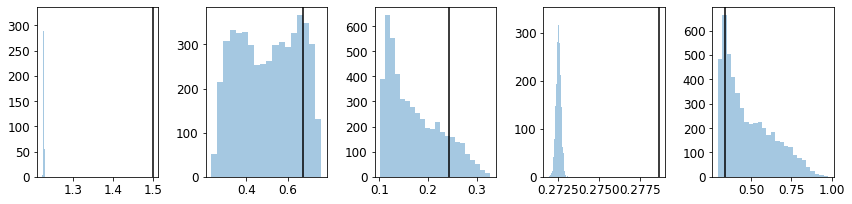

In [23]:
f, ax = plt.subplots(1, 1, figsize=(15, 10))
for i in range(5):
    ax.plot(ts[:, i], label=labels[i], lw=2)

plt.legend()
ts_t = tf.convert_to_tensor(ts[np.newaxis].reshape(1, -1), dtype=tf.float32)


theta_hat = model.sample(ts_t, 5000, to_numpy=True)

f, axarr = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    sns.distplot(theta_hat[:, i], ax=axarr[i], kde=False)
    axarr[i].axvline(parameters[i], color='black')
    
f.tight_layout()

### Variances